# 사용 패키지

In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

# 데이터 로드

In [2]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [3]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


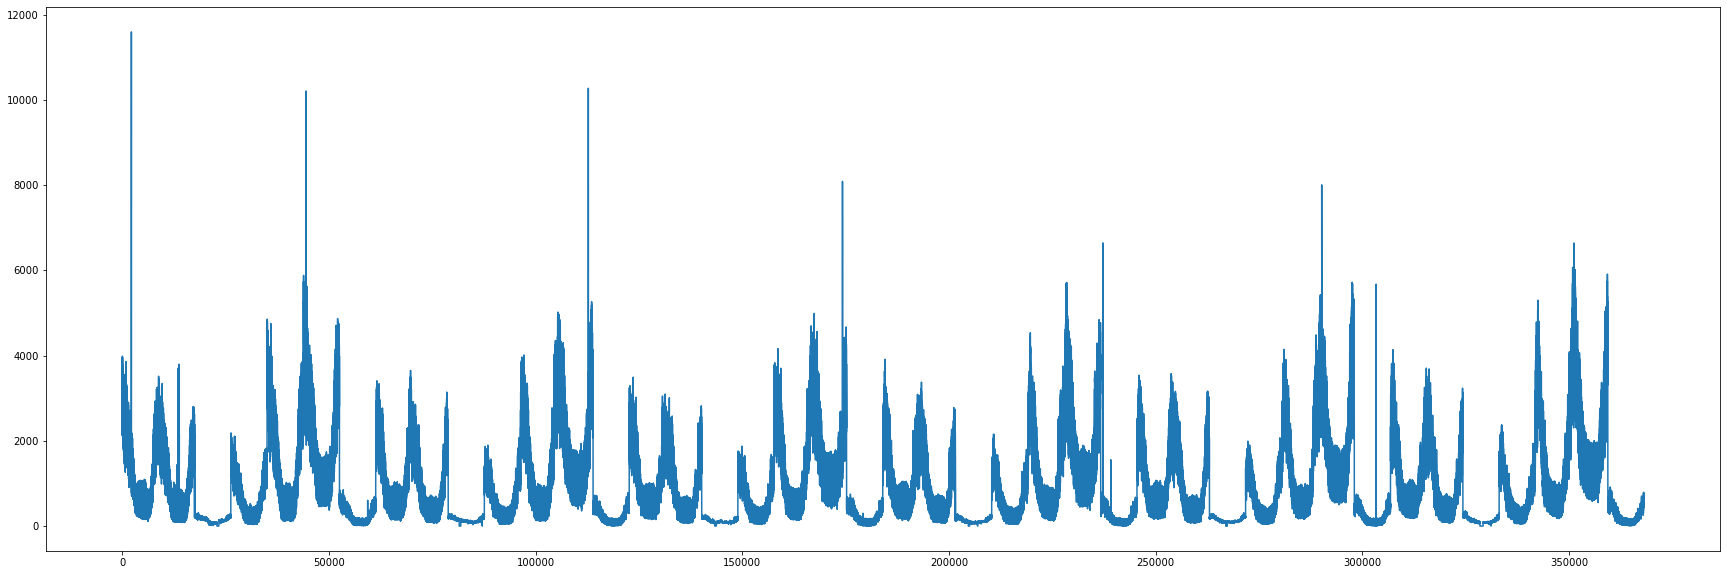

In [4]:
plt.figure(figsize=(30,10))
plt.plot(total['공급량'])   
plt.show() 

# 전처리

In [5]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [6]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [7]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [8]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [9]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [10]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [11]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

# 학습

In [12]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[16:36:10] WARNING: ..\src\learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1242.69702	eval-rmse:1369.83215
[20]	train-rmse:528.03162	eval-rmse:651.96570
[40]	train-rmse:311.36728	eval-rmse:420.69904
[60]	train-rmse:243.83742	eval-rmse:339.29681
[80]	train-rmse:216.09570	eval-rmse:305.47696
[100]	train-rmse:203.10213	eval-rmse:288.67316
[120]	train-rmse:196.05685	eval-rmse:279.66211
[140]	train-rmse:191.00378	eval-rmse:273.58984
[160]	train-rmse:187.00101	eval-rmse:269.42838
[180]	train-rmse:184.03189	eval-rmse:267.28812
[200]	train-rmse:181.11700	eval-rmse:265.83667
[220]	train-rmse:178.85255	eval-rmse:264.56039
[240]	train-rmse:176.33966	eval-rmse:263.64185
[260]	train-rmse:174.47641	eval-rmse:262.80512
[280]	train-rmse:172

# 추론 및 결과 제출

In [13]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [14]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [15]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [16]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [17]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [18]:
test['구분'] = test['구분'].map(d_map)

In [19]:
test_x = test[features]

In [20]:
test_x = xgb.DMatrix(test_x)

In [21]:
preds = model.predict(test_x)

In [22]:
submission['공급량'] = preds

In [23]:
submission.to_csv('XGBoost.csv', index=False)